In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix, make_scorer
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb

## Data quality check / cleaning / preparation 

In [2]:
# reading in the data
nba_2017 = pd.read_csv('https://raw.githubusercontent.com/Dmjohnson4/Stat-303-3-Datasets/main/NBA%20Players%20Stats%20201718.csv',
                            encoding='latin-1')
nba_2018 = pd.read_csv('https://raw.githubusercontent.com/Dmjohnson4/Stat-303-3-Datasets/main/NBA%20Players%20Stats%20201819.csv',
                            encoding = 'latin-1')

### Data cleaning
*By Davis Johnson*

In [3]:
#Train Dataset#

## getting rid of '//' characters in player names
nba_2017['Player'] = nba_2017['Player'].str.split('\\').str[0]

## If players played for more than one team, we want to only keep the row that has their total stats for the year
## applying boolean mask to get of rid of extra rows belonging to players and only keeping their 'TOT' rows
duplicated_players = nba_2017['Player'].duplicated(keep=False)
mask = duplicated_players & (nba_2017['Tm'] == 'TOT')
filtered_df = nba_2017[mask]

## creating seperate subset of players that don't have more than one row
single_team_df = nba_2017[~duplicated_players]

## combining previously created subset with players that played for more than one team and now only have one row assigned to them
nba_2017_2018 = pd.concat([filtered_df, single_team_df])
nba_2017_2018 = nba_2017_2018.reset_index(drop=True)

## filling all N/A values with 0, since we are assuming players have no stats for these data points
nba_2017_2018.fillna(0, inplace=True)


In [4]:
## repeating the process for test dataset
nba_2018['Player'] = nba_2018['Player'].str.split('\\').str[0]
duplicated_players = nba_2018['Player'].duplicated(keep=False)
mask = duplicated_players & (nba_2018['Tm'] == 'TOT')
filtered_df = nba_2018[mask]
single_team_df = nba_2018[~duplicated_players]
nba_2018_2019 = pd.concat([filtered_df, single_team_df])
nba_2018_2019 = nba_2018_2019.reset_index(drop=True)
nba_2018_2019.fillna(0, inplace=True)


### Data preparation
*By Davis Johnson*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. We want to predict All-Star appearances. Thus, we manually created a response column using binary classification. A `1` in the column signifies that the player was an All-Star in the following year.

2. We also performed some basic data preparation techniques (dropping non-relevant predictors, removing players from the analysis who appeared in a limited number of games)

In [5]:
## Train dataset

## dropping predictors that won't factor into our analysis, we our focusing on stats
nba_2017_2018 = nba_2017_2018.drop(columns=['Rk','Tm', 'Pos'], axis=1)

## removing players who played less than 20 games
nba_2017_2018 = nba_2017_2018[nba_2017_2018['G'] >= 20]
nba_2017_2018 = nba_2017_2018.reset_index(drop=True)

## converting stats into percentage form
percentage_columns = ['FG%', '3P%', '2P%', 'eFG%', 'FT%']
for col in percentage_columns:
    nba_2017_2018[col] = nba_2017_2018[col] * 100

## creating response variable
## manually creating list of the following year's NBA All-Stars
all_star_list = ['Kemba Walker', 'Kyrie Irving', 'Kawhi Leonard', 'Giannis Antetokounmpo', 
                'Joel Embiid', 'Kyle Lowry', 'Victor Oladipo', 'Khris Middleton', 'Bradley Beal',
                'Ben Simmons', 'Blake Griffin', 'Nikola Vučević', "D'Angelo Russell",
                'Stephen Curry', 'James Harden', 'Kevin Durant', 'Paul George', 'LeBron James',
                'Russell Westbrook', 'Damian Lillard', 'Klay Thompson', 'Anthony Davis', 
                'LaMarcus Aldridge', 'DeMarcus Cousins', 'Nikola Jokić', 'Karl-Anthony Towns']

## assigning a 1 to rows in a new column if the player name is in the list above
nba_2017_2018['AS_NY'] = nba_2017_2018['Player'].apply(lambda x: 1 if x in all_star_list else 0)

In [6]:
## repeating process for test dataset

nba_2018_2019 = nba_2018_2019.drop(columns=['Rk','Tm', 'Pos'], axis=1)
nba_2018_2019 = nba_2018_2019[nba_2018_2019['G'] >= 20]
nba_2018_2019 = nba_2018_2019.reset_index(drop=True)

percentage_columns = ['FG%', '3P%', '2P%', 'eFG%', 'FT%']
for col in percentage_columns:
    nba_2018_2019[col] = nba_2018_2019[col] * 100

all_star_list = ['Kemba Walker', 'Trae Young', 'Giannis Antetokounmpo', 'Pascal Siakam', 'Joel Embiid',
                'Kyle Lowry', 'Ben Simmons', 'Jimmy Butler', 'Khris Middleton', 'Bam Adebayo', 
                'Jayson Tatum', 'Domantas Sabonis', 'James Harden', 'Luka Dončić', 'LeBron James',
                'Kawhi Leonard', 'Anthony Davis', 'Chris Paul', 'Russell Westbrook', 'Damian Lillard', 
                'Donovan Mitchell', 'Brandon Ingram', 'Nikola Jokić', 'Rudy Gobert', 'Devin Booker']
nba_2018_2019['AS_NY'] = nba_2018_2019['Player'].apply(lambda x: 1 if x in all_star_list else 0)

### Distribution of response
*By Davis Johnson*

Text(0.5, 1.0, "Number of 0's and 1's")

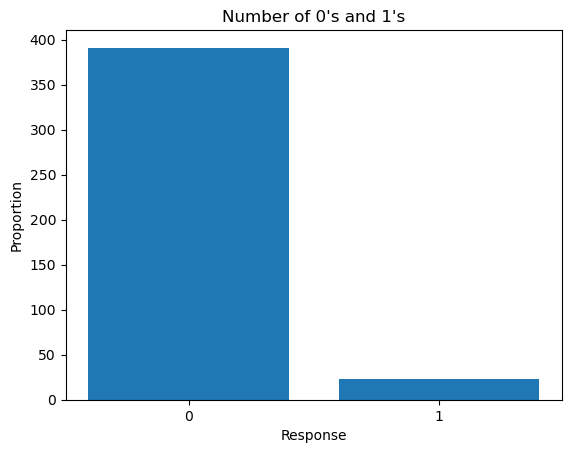

In [7]:
## bar plot for distribution of response for train data
proportions = nba_2017_2018['AS_NY'].value_counts()
plt.bar(proportions.index.astype(str), proportions.values)
plt.xlabel('Response')
plt.ylabel('Proportion')
plt.title('Number of 0\'s and 1\'s')

Text(0.5, 1.0, "Number of 0's and 1's")

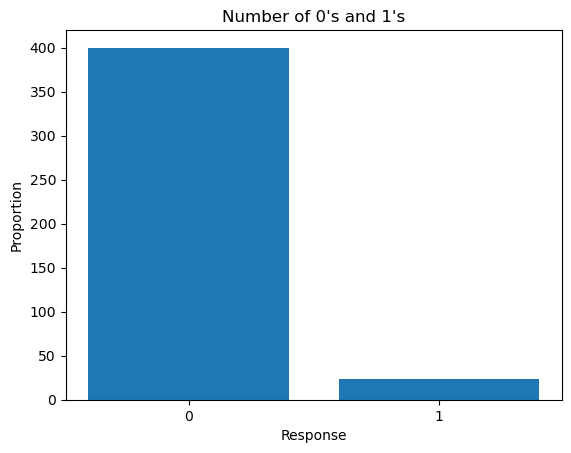

In [8]:
## bar plot for distribution of response for test data
proportions = nba_2018_2019['AS_NY'].value_counts()
plt.bar(proportions.index.astype(str), proportions.values)
plt.xlabel('Response')
plt.ylabel('Proportion')
plt.title('Number of 0\'s and 1\'s')

For both datasets, we see very skewed class distributions. This makes sense, as there are over 400 NBA players in a given year and only about 25 are voted as an All-Star each year. We do keep this in mind during model development by using StratifiedKFold.

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Correlation Table (Andy)

<Axes: >

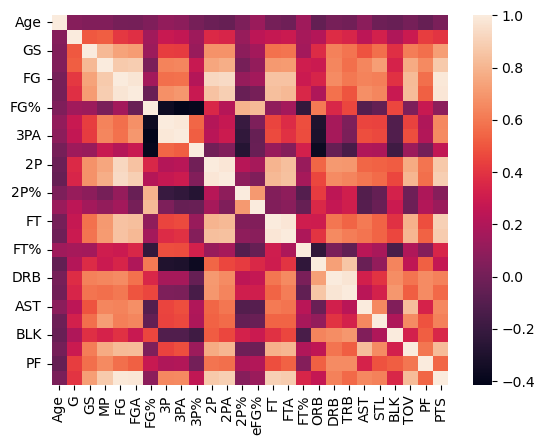

In [9]:
# developing heatmap to analyze correlations
x_train_eda = nba_2017_2018.iloc[:, 1:-1]
sns.heatmap(x_train_eda.corr())

### Variance Inflation Factor (Andy)

In [10]:
# Analyzing Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# analyze VIF for training data (2017-2018)
x_train_vif = nba_2017_2018.iloc[:, 1:-1]
X = add_constant(x_train_vif)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

# delete columns with high VIF values 
test_vif = vif_data.sort_values(by = 'VIF', ascending = False) 
test_vif

,feature,VIF
6,FGA,9278.338644
26,PTS,6855.495654
12,2PA,5214.888899
5,FG,4760.500282
20,TRB,2455.633794
9,3PA,2136.962689
11,2P,1669.580429
19,DRB,1382.304451
8,3P,568.795838
15,FT,386.671118


In [11]:
nba_2017_2018

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,AS_NY
0,Luke Babbitt,28,50,14,14.3,1.8,4.3,42.3,1.2,3.1,...,0.1,1.8,1.9,0.6,0.2,0.1,0.4,1.1,5.2,0
1,Marco Belinelli,31,80,2,24.3,4.2,9.6,44.1,1.9,4.9,...,0.3,1.6,1.9,1.9,0.8,0.2,1.2,1.1,12.1,0
2,Eric Bledsoe,28,74,74,31.4,6.3,13.4,47.3,1.7,4.9,...,0.7,3.1,3.8,5.0,2.0,0.6,2.9,2.5,17.7,0
3,Trevor Booker,30,68,7,17.0,2.6,5.0,51.6,0.1,0.5,...,1.7,3.0,4.7,1.2,0.4,0.3,0.9,1.8,6.3,0
4,Avery Bradley,27,46,46,31.2,5.6,13.6,41.4,1.6,4.4,...,0.5,2.0,2.5,2.0,1.1,0.2,2.2,2.0,14.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,Thaddeus Young,29,81,81,32.2,5.2,10.7,48.7,0.7,2.2,...,2.3,4.0,6.3,1.9,1.7,0.4,1.3,2.2,11.8,0
410,Cody Zeller,25,33,0,19.0,2.6,4.7,54.5,0.1,0.1,...,2.0,3.3,5.4,0.9,0.4,0.6,1.0,2.5,7.1,0
411,Paul Zipser,23,54,12,15.3,1.5,4.3,34.6,0.7,2.0,...,0.2,2.2,2.4,0.9,0.4,0.3,0.8,1.6,4.0,0
412,Ante _i_ià,21,32,2,6.7,1.5,2.1,73.1,0.0,0.0,...,0.8,1.1,1.9,0.2,0.1,0.4,0.3,0.9,3.7,0


In [26]:
# Analyzing Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# analyze VIF for training data (2017-2018)
x_train_vif = nba_2017_2018.iloc[:, 1:-1]
x_train_vif = x_train_vif.drop(['FGA', 'PTS', 'TRB', 'FG', '2P', 'FT', '3P', 'FG%'], axis = 1)
X = add_constant(x_train_vif)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

# delete columns with high VIF values 
test_vif = vif_data.sort_values(by = 'VIF', ascending = False) 
test_vif

,feature,VIF
0,const,170.782310
4,MP,12.043264
17,TOV,9.773210
7,2PA,6.726536
14,AST,5.237874
12,ORB,4.950500
10,FTA,4.866100
13,DRB,4.778829
5,3PA,4.620784
3,GS,3.395546


## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### Lasso, Ridge & Catboost
*By Sylvia Sherwood*

### MARS, AdaBoost & LightGBM
*By Sankaranarayanan Balasubramanian*

### Bagged trees & Random forest
*By Fiona Fe*

### XGBoost
*By Ryu Kimiko*

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

### Stacking ensemble(s)

### Ensemble of ensembled models

### Innovative ensembling methods
*(Optional)*

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.